In [1]:
import torch
import numpy as np
import pandas as pd
import random
from model_cae import model_cae
from torch.utils.data import Dataset
from utils_function import collate_fn
from scipy.special import comb
from scipy.spatial.distance import pdist, cdist

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
h_drive = "/home/amitmeghanani/H-drive/"

In [4]:
class awe_dataset_pre_computed(Dataset):
    def __init__(self, feature_df, partition):
        self.metadata = pd.read_csv(feature_df)
        self.partition = partition
        self.metadata = self.metadata[self.metadata["partition"]==self.partition]
        self.check = torch.cuda.is_available()
    
        

    def __len__(self):
        return len(self.metadata)


    def __getitem__(self, idx):
        SSL_feature_path = self.metadata.iloc[idx, 0]
        word_name = SSL_feature_path.split("/")[-1].split("_")[0]
        sp_ch_ut_id = SSL_feature_path.split("/")[-1].split("_")[-1].split(".")[0]
        if self.check:
            word_features = torch.load(SSL_feature_path)
        else:
            word_features = torch.load(h_drive + SSL_feature_path,map_location=torch.device('cpu'))
            

        return torch.squeeze(word_features),torch.tensor(word_features.size()[1]), word_name, sp_ch_ut_id

In [5]:
# For reproducibility

torch.manual_seed(3112)
torch.cuda.manual_seed(3112)
torch.cuda.manual_seed_all(3112)
np.random.seed(3112)
random.seed(3112)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(3121)

In [6]:
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

In [7]:
print("using pre-computed features")

test_data1 = awe_dataset_pre_computed(
    feature_df=h_drive + "fastdata/acw21am/private/hubert_features_1/hubert_feature_metadata.csv",
    partition="test"
)

test_data2 = awe_dataset_pre_computed(
    feature_df=h_drive+"fastdata/acw21am/private/mfcc_features_1/mfcc_feature_metadata.csv",
    partition="test"
)

using pre-computed features


In [8]:
print(len(test_data1))
print(len(test_data2))
assert len(test_data1) == len(test_data2)

9914
9914


In [9]:
# subset_index = np.arange(512)
# random.shuffle(subset_index)
# test_data1 = torch.utils.data.Subset(test_data1, subset_index)
# test_data2 = torch.utils.data.Subset(test_data2, subset_index)

In [10]:
test_loader1 = torch.utils.data.DataLoader(
  test_data1,
  batch_size=32,
  shuffle=True,
  collate_fn=collate_fn,
  drop_last = False,
  num_workers=num_workers,
  pin_memory=pin_memory,
  worker_init_fn=seed_worker,
  generator=g
)
test_loader2 = torch.utils.data.DataLoader(
  test_data2,
  batch_size=32,
  shuffle=True,
  collate_fn=collate_fn,
  drop_last = False,
  num_workers=num_workers,
  pin_memory=pin_memory,
  worker_init_fn=seed_worker,
  generator=g
)

In [11]:
model1 = model_cae(768, 256, 128, "GRU", True,4, 0.2)
checkpoint1 = torch.load("/home/amitmeghanani/H-drive/home/acw21am/e2e_subword_embedding/checkpoints/model_ssl/HUBERT_BASE_128_BEST.pt",map_location=torch.device(device))
model1.load_state_dict(checkpoint1['model_state_dict'])
model1.eval()

model_cae(
  (encoder): Encoder(
    (rnn_enc): GRU(768, 256, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
    (fc_enc): Linear(in_features=512, out_features=128, bias=True)
    (tanh): Tanh()
  )
  (decoder): Decoder(
    (rnn_dec): GRU(128, 256, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
    (fc_dec): Linear(in_features=512, out_features=768, bias=True)
  )
)

In [12]:
model2 = model_cae(60, 256, 128, "GRU", True,4, 0.2)
checkpoint2 = torch.load("/home/amitmeghanani/H-drive/home/acw21am/e2e_subword_embedding/checkpoints/model_mfcc/MFCC_128_BEST.pt",map_location=torch.device(device))
model2.load_state_dict(checkpoint2['model_state_dict'])
model2.eval()

model_cae(
  (encoder): Encoder(
    (rnn_enc): GRU(60, 256, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
    (fc_enc): Linear(in_features=512, out_features=128, bias=True)
    (tanh): Tanh()
  )
  (decoder): Decoder(
    (rnn_dec): GRU(128, 256, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
    (fc_dec): Linear(in_features=512, out_features=60, bias=True)
  )
)

In [13]:
def average_precision(data, labels, metric = "cosine", show_plot=False):
    """
    Calculate average precision and precision-recall breakeven, and return
    the average precision / precision-recall breakeven calculated
    using `same_dists` and `diff_dists`.
    -------------------------------------------------------------------
    returns average_precision, precision-recall break even : (float, float)
    """
    num_examples = len(labels)
    num_pairs = int(comb(num_examples, 2))


    # build up binary array of matching examples
    matches = np.zeros(num_pairs, dtype=bool)

    i = 0
    for n in range(num_examples):
        j = i + num_examples - n - 1
        matches[i:j] = (labels[n] == labels[n + 1:]).astype(np.int32)
        i = j

    num_same = np.sum(matches)

    # calculate pairwise distances and sort matches
    dists = pdist(data, metric=metric)
    matches = matches[np.argsort(dists)]


    # calculate precision, average precision, and recall
    precision = np.cumsum(matches) / np.arange(1, num_pairs + 1)
    average_precision = np.sum(precision * matches) / num_same
    recall = np.cumsum(matches) / num_same

    # multiple precisions can be at single recall point, take max
    for n in range(num_pairs - 2, -1, -1):
        precision[n] = max(precision[n], precision[n + 1])

    # calculate precision-recall breakeven
    prb_ix = np.argmin(np.abs(recall - precision))
    prb = (recall[prb_ix] + precision[prb_ix]) / 2.
    if show_plot:
        import matplotlib.pyplot as plt
        print("plot created")
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.savefig('12oct.pdf')
        

    return average_precision, prb, precision, recall

In [14]:
def cal_precision(model,loader,device,distance):
    embeddings, words = [], []
    model = model.eval()
    with torch.no_grad():
        for i, (data,lens,word_name,_) in enumerate(loader):
            lens, perm_idx = lens.sort(0, descending=True)
            data = data[perm_idx]
            word_name = word_name[perm_idx]

            data, lens  = data.to(device), lens.to(device)


            _,emb = model.encoder(data, lens)
            embeddings.append(emb)
            words.append(word_name)
            print(i)
        words = np.concatenate(words)
        uwords = np.unique(words)
        word2id = {v: k for k, v in enumerate(uwords)}
        ids = [word2id[w] for w in words]

        embeddings, ids = torch.cat(embeddings,0).to(torch.float16), np.array(ids)
        avg_precision,_,p,r = average_precision(embeddings.cpu(),ids, distance,show_plot=True)
        return avg_precision,p,r

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

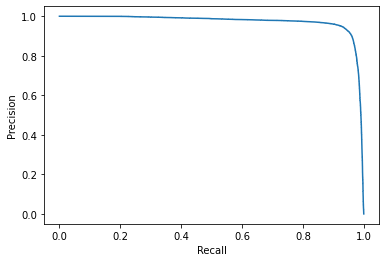

In [15]:
test_avg_precision,p_hubert,r_hubert = cal_precision(model1, test_loader1, device,"cosine")
print("average precision on test set:", test_avg_precision)
print(" We are done! Bye Bye. Have a nice day!")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

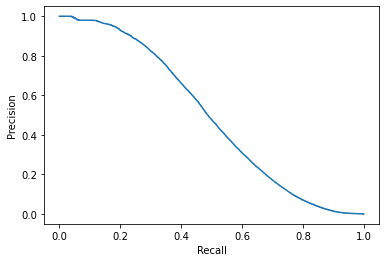

In [16]:
test_avg_precision,p_mfcc,r_mfcc = cal_precision(model2, test_loader2, device,"cosine")
print("average precision on test set:", test_avg_precision)
print(" We are done! Bye Bye. Have a nice day!")

In [17]:
import matplotlib.pyplot as plt

In [ ]:
len(p_hubert)

In [19]:
plt.plot(p_hubert, r_hubert, 'b',label="HuBERT-based CAE model")
plt.plot(p_mfcc, r_mfcc, 'r', label="MFCC-based CAE model")
plt.xlabel("Recall",fontweight='bold')
plt.ylabel("Precision",fontweight='bold')
plt.legend()
plt.savefig('pr_curve.eps', format='eps')
plt.show()

: 

: 